# Working with Tweets data
Performing EDA and sentiment analysis on tweets data.

Data publicly available at https://www.kaggle.com/datasets/kazanova/sentiment140.

Follow these steps before running the code in databricks community edition notebook:

1. Upload the csv file to DBFS in databricks before running the code.
2. Create a cluster and attach it to the notebook

**Schema:**

1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
2. ids: The id of the tweet ( 2087)
3. date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
4. flag: The query (lyx). If there is no query, then this value is NO_QUERY.
5. user: the user that tweeted (robotickilldozr)
6. text: the text of the tweet (Lyx is cool)


### Install PySpark
If you are not running the code in a databricks notebook and don't have PySpark installed on your system.

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,228 kB]
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,561 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main

### Install Required Packages


In [2]:
!pip install typing-extensions==4.12.2
!pip install nltk==3.9.1

### Import Modules

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import col, count, when, desc, length, explode, split, regexp_extract
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

### Define global variables and create PySpark session

In [9]:
# Input csv file
tweets_csv = "PATH_TO/tweets_data.csv"

# Intermediate parquet file
conf_mat_parquet_file = "PATH_TO/confusion_matrix_df.parquet"

# Create session
spark = SparkSession.builder.appName("Tweets Analysis").getOrCreate()

### Import CSV and Create DataFrame

In [10]:

# Define the schema explicitly
df_schema = StructType([
    StructField("target", IntegerType(), True),
    StructField("id", IntegerType(), True),
    StructField("date", StringType(), True),
    StructField("flag", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True)
])

In [11]:
# Read CSV file into a PySpark DataFrame
tweets_df = spark.read.csv( tweets_csv, header=True,              # Ensures the first row is treated as headers
    schema=df_schema          # Automatically infers column data types
)

### Exploratory Data Analysis

In [ ]:
# -----------------------------------------------
# 1. General Summary
# -----------------------------------------------
# Display schema and preview data
tweets_df.printSchema()

# Target label values distribution
print("Distribution of Target Sentiment:")
tweets_df.groupBy("target").count().orderBy(desc("count")).show()

# Unique users
unique_users = tweets_df.select("user").distinct().count()
print(f"Number of unique users: {unique_users}")

# Null value counts
null_counts = tweets_df.select([count(when(col(c).isNull(), c)).alias(c) for c in tweets_df.columns])
print("Null values in each column:")
null_counts.show()


root
 |-- target: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

Distribution of Target Sentiment:
+------+------+
|target| count|
+------+------+
|     4|800000|
|     0|799999|
+------+------+

Number of unique users: 659775
Null values in each column:
+------+------+----+----+----+----+
|target|    id|date|flag|user|text|
+------+------+----+----+----+----+
|     0|432913|   0|   0|   0|   0|
+------+------+----+----+----+----+



In [ ]:
# -----------------------------------------------
# 2. Text Analysis
# -----------------------------------------------

# Add tweet length column
tweets_text_df = tweets_df.withColumn("text_length", length(col("text")))

# Analyze tweet text lengths
print("Tweet Text Length Statistics:")
tweets_text_df.select("text_length").describe().show()

# Extract hashtags
tweets_text_df = tweets_text_df.withColumn("hashtags", split(col("text"), " "))
tweets_text_df = tweets_text_df.withColumn("hashtags", explode(col("hashtags")))
tweets_text_df = tweets_text_df.withColumn("hashtags", regexp_extract(col("hashtags"), r"#(\w+)", 1))

# Top hashtags
print("\nTop Hashtags:")
tweets_text_df.filter(col("hashtags") != "").groupBy("hashtags").count().orderBy(desc("count")).show(10)


Tweet Text Length Statistics:
+-------+-----------------+
|summary|      text_length|
+-------+-----------------+
|  count|          1599999|
|   mean| 74.0417337760836|
| stddev|36.38798911935337|
|    min|                6|
|    max|              359|
+-------+-----------------+


Top Hashtags:
+------------+-----+
|    hashtags|count|
+------------+-----+
|followfriday| 2114|
|          fb| 1746|
| squarespace|  888|
|          FF|  586|
|           1|  519|
|         seb|  499|
|FollowFriday|  463|
| musicmonday|  400|
|          ff|  399|
|iranelection|  359|
+------------+-----+
only showing top 10 rows



In [ ]:
# -----------------------------------------------
# 3. User Analysis
# -----------------------------------------------

# Tweets per user
print("Top Users by Number of Tweets:")
tweets_df.groupBy("user").count().orderBy(desc("count")).show(10)


Top Users by Number of Tweets:
+---------------+-----+
|           user|count|
+---------------+-----+
|       lost_dog|  549|
|        webwoke|  345|
|       tweetpet|  310|
|SallytheShizzle|  281|
|    VioletsCRUK|  279|
|    mcraddictal|  276|
|       tsarnick|  248|
|    what_bugs_u|  246|
|    Karen230683|  238|
|      DarkPiano|  236|
+---------------+-----+
only showing top 10 rows



In [ ]:
# -----------------------------------------------
# 4. Temporal Analysis
# -----------------------------------------------

# Extract hour from the timestamp
tweets_temp_df = tweets_df.withColumn("hour", regexp_extract(col("date"), r"\d{2}:\d{2}:\d{2}", 0).substr(1, 2).cast("integer"))

# Tweets by hour of day
print("Tweet Distribution by Hour of Day:")
tweets_temp_df.groupBy("hour").count().orderBy(desc("count")).show()


Tweet Distribution by Hour of Day:
+----+-----+
|hour|count|
+----+-----+
|  23|84750|
|   7|83654|
|   0|80865|
|   6|80852|
|   5|78623|
|  22|78327|
|   4|76995|
|   8|76287|
|   1|75268|
|   3|74253|
|   2|73991|
|  21|68964|
|   9|67278|
|  11|61009|
|  10|60689|
|  19|57722|
|  20|57059|
|  16|55720|
|  18|53485|
|  17|51843|
+----+-----+
only showing top 20 rows



In [ ]:
# -----------------------------------------------
# 5. User mentions Code
# -----------------------------------------------

# Create a user-interaction network based on mentions in tweets.
tweets_mentions_df = tweets_df.withColumn("mentions", regexp_extract(col("text"), r"@(\w+)", 1))
mention_edges = tweets_mentions_df.filter(col("mentions") != "").select("user", "mentions")

mention_edges.groupBy("user", "mentions").count().orderBy(desc("count")).show(10)

+---------------+-------------+-----+
|           user|     mentions|count|
+---------------+-------------+-----+
|     19fischi75|   Impala_Guy|   83|
|SallytheShizzle|   OfficialAS|   78|
|     Impala_Guy|   19fischi75|   68|
|      keren4562|     tommcfly|   65|
|        Recamel| TheSUPERGIRL|   59|
|     QueenBxoxo|    xbllygbsn|   56|
|  Jeff_Hardyfan|   mileycyrus|   55|
|      karinb_za|      astynes|   52|
|   sierrabardot|   mileycyrus|   51|
|     sebby_peek|amazingphoebe|   45|
+---------------+-------------+-----+
only showing top 10 rows



### Sentiment Analysis
Analyzing tweets based on the positivity and negativity of words, along with semantic meaning of the sentence.

In [12]:

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Define UDF for VADER Sentiment Analysis
def vader_sentiment(text):
    if not text or not isinstance(text, str):
        return 3  # Neutral fallback
    scores = analyzer.polarity_scores(text)
    compound = scores['compound']
    # Convert compound score to a rating (1 to 5)

    if compound < 0:
        return 0  # Negative

    elif compound == 0:
        return 1  # Neutral

    else:
        return 4  # Positive

# Register UDF
vader_udf = udf(vader_sentiment, IntegerType())

# Apply UDF to DataFrame
tweets_df = tweets_df.withColumn("sentiment_rating", vader_udf(col("text")))

## Performance Evaluation
Calculate key metrics such as Recall, Precision, and Confusion matrix to evaluate the model's performance.

### Mapping neutral values before evaluation
The actual label doesn't have any neutral values. So, to avoid skewing the predicted data and incorporate all rows for performance evaluation, it is best to replace the predicted neutral values with their actual values.

In [13]:
from pyspark.sql import functions as F

tweets_df = tweets_df.withColumn(
    "predicted",
    F.when((F.col("target") == 0) & (F.col("sentiment_rating") == 1), 0)
     .when((F.col("target") == 4) & (F.col("sentiment_rating") == 1), 4)
     .otherwise(F.col("sentiment_rating"))  # Keep existing predicted values for other rows
)

# Drop unnecessary columns to reduce data size
tweets_df = tweets_df.drop("text", "id", "date", "flag", "user", "sentiment_rating")

### Create confusion_matrix and write as a parquet file
Spark performs lazy processing: a lot of commands are chained and only executed when result is requested. So it is better to write the small confusion matrix file and read that file for further use. Otherwise all the commands chained to create the confusion_matrix dataframe will be executed every time confusion_matrix dataframe is referenced/ called.

In [16]:
# Create confusion matrix counts
confusion_matrix = (
    tweets_df.groupBy("target", "predicted")
    .count()
    .withColumnRenamed("count", "value")
)

confusion_matrix.write.mode("overwrite").parquet(conf_mat_parquet_file)

print("Confusion matrix file written successfully")

Confusion matrix file written successfully


### Read file and display TP, FN, FP and TN

In [15]:
confusion_matrix = spark.read.parquet(conf_mat_parquet_file)

confusion_matrix.show()

# Define positive and negative labels
positive_label = 4
negative_label = 0

# confusion_matrix.cache()

# Extract TP, TN, FP, FN
metrics_df = confusion_matrix.groupBy().agg(
    F.sum(F.when((F.col("target") == positive_label) & (F.col("predicted") == positive_label), F.col("value"))).alias("TP"),
    F.sum(F.when((F.col("target") == negative_label) & (F.col("predicted") == negative_label), F.col("value"))).alias("TN"),
    F.sum(F.when((F.col("target") == negative_label) & (F.col("predicted") == positive_label), F.col("value"))).alias("FP"),
    F.sum(F.when((F.col("target") == positive_label) & (F.col("predicted") == negative_label), F.col("value"))).alias("FN")
)

metrics_df.show()

+------+---------+------+
|target|predicted| value|
+------+---------+------+
|     4|        0| 81469|
|     0|        0|545519|
|     4|        4|718531|
|     0|        4|254480|
+------+---------+------+

+------+------+------+-----+
|    TP|    TN|    FP|   FN|
+------+------+------+-----+
|718531|545519|254480|81469|
+------+------+------+-----+



#### Precision, Recall, F1 and Accuracy

In [17]:
# Calculate metrics
metrics_df = metrics_df.withColumn("Precision", F.round(F.col("TP") / (F.col("TP") + F.col("FP")), 3))
metrics_df = metrics_df.withColumn("Recall", F.round(F.col("TP") / (F.col("TP") + F.col("FN")), 3))
metrics_df = metrics_df.withColumn("F1", F.round((2 * F.col("Precision") * F.col("Recall")) / (F.col("Precision") + F.col("Recall")), 3))
metrics_df = metrics_df.withColumn("Accuracy", F.round((F.col("TP") + F.col("TN")) / (F.col("TP") + F.col("TN") + F.col("FP") + F.col("FN")), 3))

metrics_df.show()

+------+------+------+-----+---------+------+----+--------+
|    TP|    TN|    FP|   FN|Precision|Recall|  F1|Accuracy|
+------+------+------+-----+---------+------+----+--------+
|718531|545519|254480|81469|    0.738| 0.898|0.81|    0.79|
+------+------+------+-----+---------+------+----+--------+



### Plot values

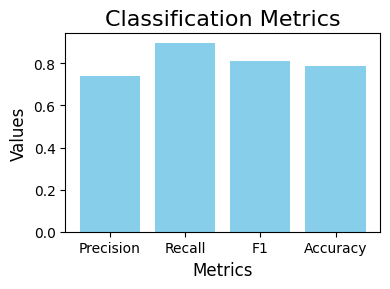

In [18]:
import matplotlib.pyplot as plt
# Convert metrics_df to Pandas DataFrame
metrics_pd = metrics_df.select("Precision", "Recall", "F1", "Accuracy").toPandas()

# Extract the metrics values from the DataFrame (only the first row)
metrics_values = metrics_pd.iloc[0]

# Create a bar chart
plt.figure(figsize=(4, 3))
plt.bar(metrics_values.index, metrics_values.values, color='skyblue')

# Add title and labels
plt.title('Classification Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Values', fontsize=12)

# Display the chart
plt.tight_layout()
plt.show()

### Interpreting Results:
Model has a higher recall and a lower precision. That means the VADER model is better at correctly predicting tweets with a positive sentiment score.